In [8]:
import itertools
import os
import scipy

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.15.0
GPU is NOT AVAILABLE


In [9]:
from keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/home/fadheld/AI/dataset/train'
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.4)
  # Normalize pixel values between 0 and 1

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=5,
    class_mode='binary'
    )

        
VALIDATION_DIR = '/home/fadheld/AI/dataset/test'
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize pixel values between 0 and 1

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
VALIDATION_DIR,
target_size=(150, 150),  # Resize images to 150x150
batch_size=8,
class_mode='binary')

Found 1125 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:

history = model.fit(
    train_generator,
    epochs=30,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback]
)


Epoch 1/30
225/225 [==============================] - 29s 122ms/step - loss: 0.6365 - accuracy: 0.7236 - val_loss: 0.5791 - val_accuracy: 0.7289
Epoch 2/30
225/225 [==============================] - 24s 109ms/step - loss: 0.5739 - accuracy: 0.7244 - val_loss: 0.5599 - val_accuracy: 0.7436
Epoch 3/30
225/225 [==============================] - 26s 114ms/step - loss: 0.5589 - accuracy: 0.7396 - val_loss: 0.5775 - val_accuracy: 0.7436
Epoch 4/30
225/225 [==============================] - 25s 112ms/step - loss: 0.5247 - accuracy: 0.7520 - val_loss: 0.5386 - val_accuracy: 0.7473
Epoch 5/30
225/225 [==============================] - 25s 110ms/step - loss: 0.5060 - accuracy: 0.7573 - val_loss: 0.5271 - val_accuracy: 0.7399
Epoch 6/30
225/225 [==============================] - 25s 113ms/step - loss: 0.5098 - accuracy: 0.7689 - val_loss: 0.5320 - val_accuracy: 0.7729
Epoch 7/30
225/225 [==============================] - 25s 112ms/step - loss: 0.4957 - accuracy: 0.7653 - val_loss: 0.4724 - val_ac

In [15]:
model.save('model_car.h5')

/home/fadheld/AI/aienv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
load_model = tf.keras.models.load_model('model_car.h5')

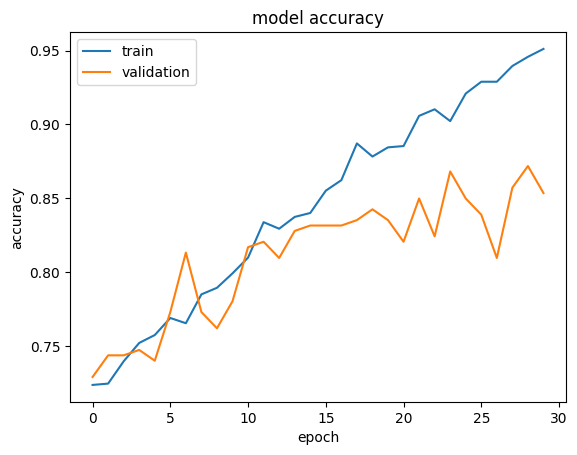

<Figure size 640x480 with 0 Axes>

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.savefig(os.path.join(save_dir, save_filename))

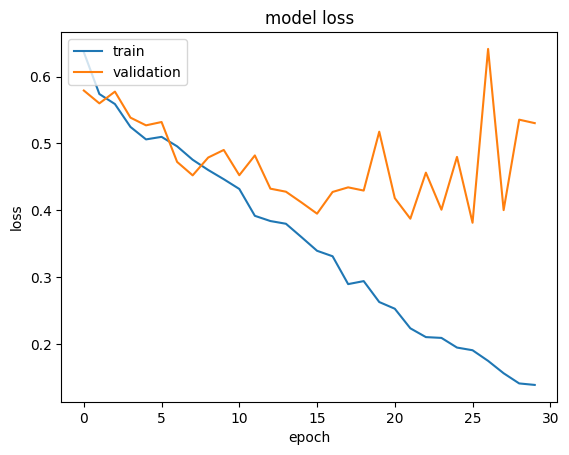

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
score = model.evaluate(validation_generator, batch_size=1)
print("Validation Loss :", score[0])
print("Validation Accuracy :", score[1])

35/35 [==============================] - 1s 38ms/step - loss: 0.5304 - accuracy: 0.8535
Validation Loss : 0.5303641557693481
Validation Accuracy : 0.8534798622131348


In [29]:
from keras.preprocessing import image


def predict_image_class(image_path, model):
    img = image.load_img(image_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    classes = model.predict(x)  # Use the loaded model for prediction
    return classes[0][0]

# Upload an image from your local system
def upload_and_predict(model):
    image_path = input("Enter the file path of the image: ")
    confidence = predict_image_class(image_path, model)
    predicted_class = "Rolls royce" if confidence > 0.5 else "Audi"
    return predicted_class

# Perform the image upload and prediction
predicted_label = upload_and_predict(model)
print(predicted_label)


1/1 [==============================] - 0s 27ms/step
Rolls royce


https://www.kaggle.com/datasets/kshitij192/cars-image-dataset/code